<a href="https://colab.research.google.com/github/driano1221/Desafio-de-Machine-Learning/blob/main/Modelo_Classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Estat√≠stica descritiva breve para rupturas_minimo.xlsx (Google Colab) ---


import pandas as pd
import numpy as np
import re

# Caminho do arquivo (como voc√™ indicou):
path = "/content/drive/MyDrive/Colab Notebooks/rupturas_minimo.xlsx"

# Leitura
df = pd.read_excel(path)  # engine="openpyxl" ser√° usado automaticamente no Colab
print(df)
# --- Valida√ß√µes e preparo ---
# Esperado: ['registro', 'tipo', 'p1'...'p7']
expected_tipo = {"a1","a2","b","c","d","e","f","g","h"}
p_cols = [c for c in df.columns if re.fullmatch(r"p[1-7]", str(c))]
if not p_cols:
    raise ValueError("N√£o encontrei colunas p1..p7. Verifique o arquivo.")

# Converte flags p1..p7 para num√©rico (0/1), preservando NA se houver
df[p_cols] = df[p_cols].apply(pd.to_numeric, errors="coerce")

# N√∫mero de particularidades por registro
df["n_particularidades"] = df[p_cols].sum(axis=1)

# --- 1) Vis√£o geral ---
print("=== VIS√ÉO GERAL ===")
print("Formato (linhas, colunas):", df.shape)
print("\nColunas:", list(df.columns))
print("\nTipos de dados:")
print(df.dtypes)

print("\nValores ausentes por coluna:")
print(df.isna().sum())

# --- 2) Distribui√ß√£o de 'tipo' ---
print("\n=== DISTRIBUI√á√ÉO DE 'tipo' ===")
tipo_counts = df["tipo"].value_counts(dropna=False).sort_index()
tipo_pct = (df["tipo"].value_counts(normalize=True, dropna=False).sort_index() * 100).round(2)
print(pd.DataFrame({"contagem": tipo_counts, "percentual_%": tipo_pct}))

# --- 3) Flags de particularidades (p1..p7) ---
print("\n=== FLAGS p1..p7 (geral) ===")
flags_summary = pd.DataFrame({
    "soma": df[p_cols].sum(),
    "proporcao_%": (df[p_cols].mean() * 100).round(2)
}).astype({"soma": int})
print(flags_summary)

# --- 4) N√∫mero de particularidades por registro ---
print("\n=== N¬∫ de particularidades por registro ===")
npart_counts = df["n_particularidades"].value_counts().sort_index()
npart_pct = (df["n_particularidades"].value_counts(normalize=True).sort_index() * 100).round(2)
print(pd.DataFrame({"contagem": npart_counts, "percentual_%": npart_pct}))

# --- 5) Perfil por 'tipo': m√©dia das flags (% de ocorr√™ncia) e n por tipo ---
print("\n=== PERFIL POR 'tipo' (m√©dia das flags como %) ===")
tipo_n = df["tipo"].value_counts().rename("n")
tipo_flags = (df.groupby("tipo")[p_cols].mean() * 100).round(1)
perfil_tipo = tipo_flags.merge(tipo_n, left_index=True, right_index=True)
# Ordena por n desc para facilitar leitura
perfil_tipo = perfil_tipo.sort_values("n", ascending=False)
print(perfil_tipo)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/rupturas_minimo.xlsx'

## Projeto de fato


In [ ]:
# Importando as bibliotecas necess√°rias
import os
import pandas as pd
import shutil
import glob # √ìtimo para encontrar arquivos com padr√µes espec√≠ficos

# Montar o Google Drive no ambiente do Colab
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- CAMINHOS QUE VOC√ä PRECISA CONFIGURAR ---

# Caminho para o seu arquivo Excel com os r√≥tulos
caminho_excel = "/content/drive/MyDrive/Colab Notebooks/rupturas_minimo.xlsx"

# Caminho para a pasta onde TODAS as imagens de vistas est√£o juntas
pasta_origem_imagens = "/content/drive/MyDrive/Colab Notebooks/vistas_separadas"

# Caminho para a nova pasta que ser√° criada para armazenar o dataset organizado
# Vamos criar esta pasta fora do Drive para maior velocidade de acesso durante o treinamento.
# Se preferir salvar no Drive, altere para: '/content/drive/MyDrive/Colab Notebooks/dataset_organizado'
pasta_destino_dataset = "/content/dataset_organizado"



In [ ]:
# Carregar a planilha para um DataFrame do Pandas
try:
    df_rupturas = pd.read_excel(caminho_excel)
    # print(df_rupturas.head()) # Descomente para ver as primeiras linhas
except FileNotFoundError:
    print(f"ERRO: O arquivo Excel n√£o foi encontrado em: {caminho_excel}")
    # Interrompe a execu√ß√£o se o arquivo n√£o for encontrado
    raise

# Obter os nomes √∫nicos das classes de ruptura da coluna 'tipo'
tipos_unicos = df_rupturas['tipo'].unique()

print("\nTipos de ruptura encontrados:", tipos_unicos)

# Criar a pasta principal do dataset, se ela n√£o existir
os.makedirs(pasta_destino_dataset, exist_ok=True)

# Criar uma subpasta para cada tipo de ruptura
for tipo in tipos_unicos:
    caminho_da_classe = os.path.join(pasta_destino_dataset, str(tipo))
    os.makedirs(caminho_da_classe, exist_ok=True)




Tipos de ruptura encontrados: ['a1' 'a2' 'e' 'd' 'f' 'g']


In [ ]:
print("Iniciando a organiza√ß√£o das imagens. Isso pode levar alguns minutos...")

# Contador para verificar o sucesso da opera√ß√£o
imagens_copiadas = 0
imagens_nao_encontradas_no_df = 0

# Criar um mapeamento de 'registro' para 'tipo' para acesso r√°pido
# Isso √© muito mais eficiente do que pesquisar o DataFrame a cada itera√ß√£o
mapeamento_registro_tipo = pd.Series(df_rupturas.tipo.values, index=df_rupturas.registro).to_dict()

# Encontrar todos os arquivos .jpg na pasta de origem
lista_de_imagens = glob.glob(os.path.join(pasta_origem_imagens, '*.jpg'))

if not lista_de_imagens:
    print(f"AVISO: Nenhuma imagem .jpg foi encontrada na pasta de origem: {pasta_origem_imagens}")

for caminho_imagem_origem in lista_de_imagens:
    try:
        # Extrair o nome do arquivo (ex: '657_vista4.jpg')
        nome_arquivo = os.path.basename(caminho_imagem_origem)

        # Extrair o n√∫mero do registro do nome do arquivo
        registro_id = int(nome_arquivo.split('_')[0])

        # Encontrar o tipo de ruptura usando nosso mapeamento
        if registro_id in mapeamento_registro_tipo:
            tipo_ruptura = mapeamento_registro_tipo[registro_id]

            # Construir o caminho completo de destino
            caminho_final = os.path.join(pasta_destino_dataset, str(tipo_ruptura), nome_arquivo)

            # Copiar o arquivo
            shutil.copy(caminho_imagem_origem, caminho_final)
            imagens_copiadas += 1
        else:
            # Caso o registro da imagem n√£o esteja na planilha
            print(f"Aviso: Registro {registro_id} (do arquivo {nome_arquivo}) n√£o encontrado na planilha.")
            imagens_nao_encontradas_no_df += 1

    except (ValueError, IndexError) as e:
        print(f"Aviso: N√£o foi poss√≠vel processar o arquivo '{nome_arquivo}'. Verifique o padr√£o de nome. Erro: {e}")

print("\n--- Processo Finalizado! ---")
print(f"Total de imagens copiadas com sucesso: {imagens_copiadas}")
print(f"Imagens cujo registro n√£o foi encontrado na planilha: {imagens_nao_encontradas_no_df}")

Iniciando a organiza√ß√£o das imagens. Isso pode levar alguns minutos...
Aviso: Registro 716 (do arquivo 716_vista5.jpg) n√£o encontrado na planilha.
Aviso: Registro 716 (do arquivo 716_vista3.jpg) n√£o encontrado na planilha.
Aviso: Registro 716 (do arquivo 716_vista2.jpg) n√£o encontrado na planilha.
Aviso: Registro 716 (do arquivo 716_vista4.jpg) n√£o encontrado na planilha.
Aviso: Registro 717 (do arquivo 717_vista2.jpg) n√£o encontrado na planilha.
Aviso: Registro 717 (do arquivo 717_vista3.jpg) n√£o encontrado na planilha.
Aviso: Registro 717 (do arquivo 717_vista5.jpg) n√£o encontrado na planilha.
Aviso: Registro 717 (do arquivo 717_vista4.jpg) n√£o encontrado na planilha.

--- Processo Finalizado! ---
Total de imagens copiadas com sucesso: 527
Imagens cujo registro n√£o foi encontrado na planilha: 8


In [ ]:
print("--- Verifica√ß√£o Final: Contagem de imagens por classe ---")

total_imagens_organizadas = 0

# Itera sobre as pastas de cada classe que foram criadas
for nome_pasta in sorted(os.listdir(pasta_destino_dataset)):
    caminho_pasta_classe = os.path.join(pasta_destino_dataset, nome_pasta)

    # Verifica se √© um diret√≥rio
    if os.path.isdir(caminho_pasta_classe):
        # Conta o n√∫mero de arquivos na pasta
        num_arquivos = len(os.listdir(caminho_pasta_classe))
        print(f"Classe '{nome_pasta}': {num_arquivos} imagens")
        total_imagens_organizadas += num_arquivos

print("---------------------------------------------------------")
print(f"Total de imagens no dataset organizado: {total_imagens_organizadas}")

--- Verifica√ß√£o Final: Contagem de imagens por classe ---
Classe 'a1': 26 imagens
Classe 'a2': 275 imagens
Classe 'd': 45 imagens
Classe 'e': 58 imagens
Classe 'f': 8 imagens
Classe 'g': 115 imagens
---------------------------------------------------------
Total de imagens no dataset organizado: 527


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import mobilenet_v2

# ==============================================================================
# 1. CONFIGURA√á√ÉO
# ==============================================================================
# Ajuste estes par√¢metros conforme necess√°rio.

# Onde o dataset organizado no Passo 2 est√° localizado.
BASE_DATA_DIR = "/content/dataset_organizado"

# Classes a serem utilizadas nesta primeira "prova de conceito".
VIABLE_CLASSES = ['a2', 'g', 'e', 'd']

# Par√¢metros para o modelo e o gerador de dados.
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.20  # 20% dos dados ser√£o usados para valida√ß√£o.
RANDOM_STATE = 42      # Para reprodutibilidade da divis√£o dos dados.


# ==============================================================================
# 2. CARREGAMENTO E FILTRAGEM DOS DADOS
# ==============================================================================
# Coleta os caminhos de todas as imagens e os filtra pelas classes vi√°veis.

all_image_paths = []
all_labels = []

print(f"Buscando imagens em: {BASE_DATA_DIR}")
print(f"Filtrando apenas para as classes: {VIABLE_CLASSES}\n")

for class_label in os.listdir(BASE_DATA_DIR):
    if class_label in VIABLE_CLASSES:
        class_dir = os.path.join(BASE_DATA_DIR, class_label)
        for image_file in os.listdir(class_dir):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_image_paths.append(os.path.join(class_dir, image_file))
                all_labels.append(class_label)

# Verifica√ß√£o inicial
if not all_image_paths:
    raise FileNotFoundError(f"Nenhuma imagem encontrada para as classes vi√°veis em '{BASE_DATA_DIR}'. Verifique o caminho.")

print(f"Total de imagens encontradas para as classes vi√°veis: {len(all_image_paths)}")




Buscando imagens em: /content/dataset_organizado
Filtrando apenas para as classes: ['a2', 'g', 'e', 'd']

Total de imagens encontradas para as classes vi√°veis: 493


In [ ]:
# ==============================================================================
# 3. DIVIS√ÉO ESTRATIFICADA DOS DADOS
# ==============================================================================
# Divide os dados em conjuntos de treino e valida√ß√£o mantendo a propor√ß√£o
# original das classes em ambos os conjuntos.

X_train, X_val, y_train, y_val = train_test_split(
    all_image_paths,
    all_labels,
    test_size=VALIDATION_SPLIT,
    random_state=RANDOM_STATE,
    stratify=all_labels  # Garante a propor√ß√£o das classes.
)

# Cria DataFrames para alimentar os geradores, uma pr√°tica profissional e robusta.
train_df = pd.DataFrame({'filepath': X_train, 'class': y_train})
validation_df = pd.DataFrame({'filepath': X_val, 'class': y_val})

print("\n--- Distribui√ß√£o das Classes Ap√≥s Divis√£o ---")
print("\nConjunto de Treino:")
print(train_df['class'].value_counts(normalize=True).round(3))
print(f"\nTotal de treino: {len(train_df)} imagens")

print("\nConjunto de Valida√ß√£o:")
print(validation_df['class'].value_counts(normalize=True).round(3))
print(f"Total de valida√ß√£o: {len(validation_df)} imagens\n")


# ==============================================================================
# 4. CRIA√á√ÉO DOS GERADORES DE IMAGEM (ImageDataGenerator)
# ==============================================================================
# Configura os geradores que ir√£o carregar, pr√©-processar e aumentar os dados
# em tempo real durante o treinamento.

# Gerador para o conjunto de treino com Data Augmentation "cuidadoso".
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=False,  # Essencial: n√£o inverter a imagem.
    vertical_flip=False,    # Essencial: n√£o inverter a imagem.
    fill_mode='reflect',
    preprocessing_function=mobilenet_v2.preprocess_input # Normaliza os pixels para o padr√£o do MobileNetV2 [-1, 1].
)

# Gerador para o conjunto de valida√ß√£o, sem Data Augmentation.
# Apenas a normaliza√ß√£o de pixels √© aplicada.
validation_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_v2.preprocess_input
)

# Cria os geradores a partir dos DataFrames.
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='class',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='filepath',
    y_col='class',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # N√£o √© necess√°rio embaralhar os dados de valida√ß√£o.
)

# ==============================================================================
# 5. VERIFICA√á√ÉO FINAL
# ==============================================================================
print("\n--- Status Final do Passo 3 ---")
print(f"Gerador de treino pronto: {train_generator.n} imagens em {len(train_generator.class_indices)} classes, divididas em {len(train_generator)} lotes.")
print(f"Gerador de valida√ß√£o pronto: {validation_generator.n} imagens em {len(validation_generator.class_indices)} classes, divididas em {len(validation_generator)} lotes.")



--- Distribui√ß√£o das Classes Ap√≥s Divis√£o ---

Conjunto de Treino:
class
a2    0.558
g     0.234
e     0.117
d     0.091
Name: proportion, dtype: float64

Total de treino: 394 imagens

Conjunto de Valida√ß√£o:
class
a2    0.556
g     0.232
e     0.121
d     0.091
Name: proportion, dtype: float64
Total de valida√ß√£o: 99 imagens

Found 394 validated image filenames belonging to 4 classes.
Found 99 validated image filenames belonging to 4 classes.

--- Status Final do Passo 3 ---
Gerador de treino pronto: 394 imagens em 4 classes, divididas em 13 lotes.
Gerador de valida√ß√£o pronto: 99 imagens em 4 classes, divididas em 4 lotes.


### Testando e validando passo 3

Visualizando um lote de imagens do gerador de treino...


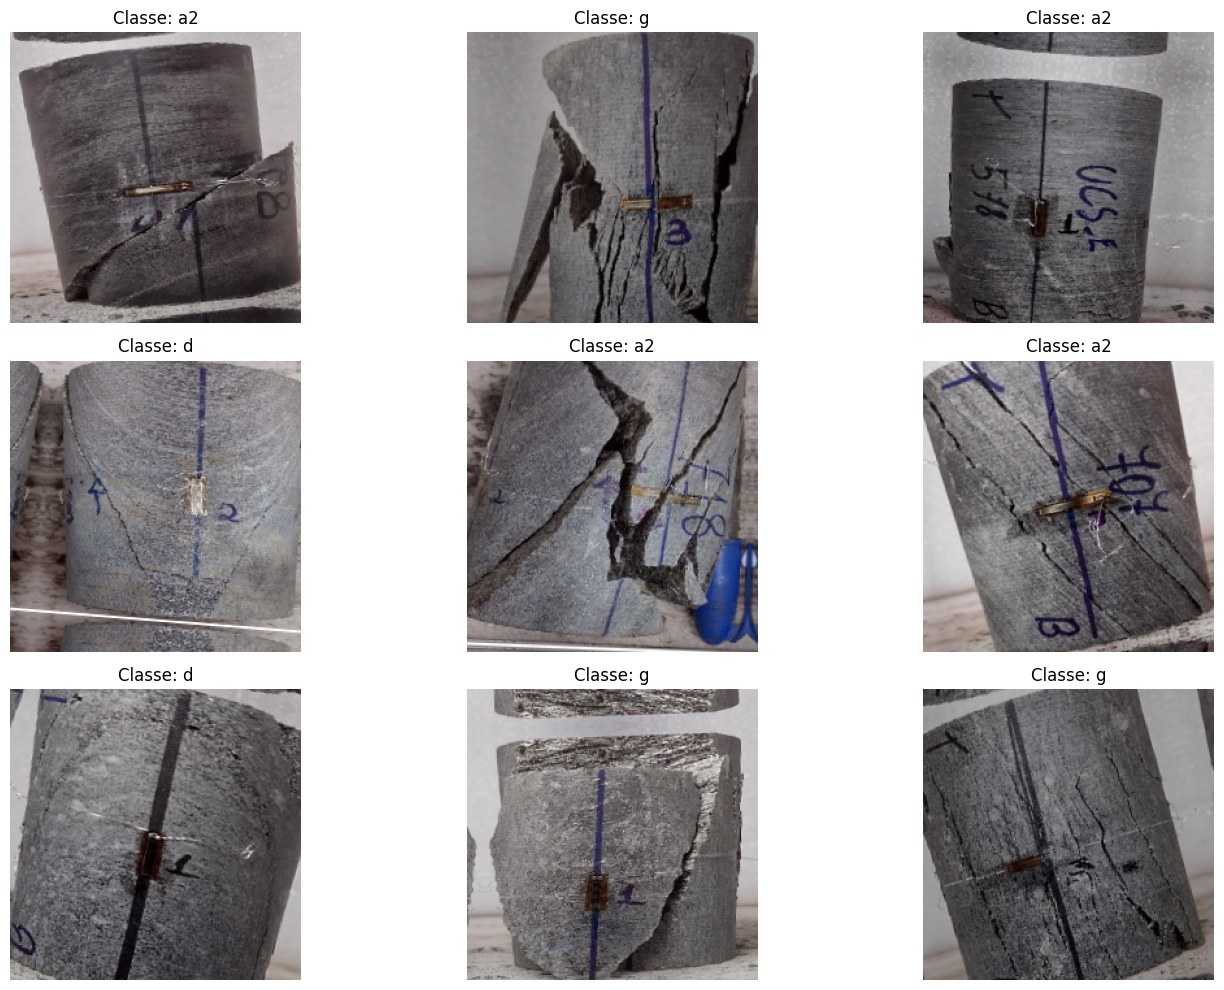


Forma do lote de imagens (Batch, Altura, Largura, Canais): (32, 224, 224, 3)
Forma do lote de r√≥tulos (Batch, Num_Classes): (32, 4)
Intervalo de valores dos pixels (Min): -1.00
Intervalo de valores dos pixels (Max): 1.00


In [ ]:
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# C√ìDIGO DE VISUALIZA√á√ÉO
# ------------------------------------------------------------------------------

print("Visualizando um lote de imagens do gerador de treino...")

# Pega o pr√≥ximo lote de imagens e r√≥tulos do gerador.
images, labels = next(train_generator)

# Inverte o dicion√°rio de classes para mapear o √≠ndice de volta para o nome da classe.
# Ex: {0: 'a2', 1: 'd', 2: 'e', 3: 'g'}
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}

# Define o tamanho da grade de visualiza√ß√£o.
plt.figure(figsize=(15, 10))

# Mostra as 9 primeiras imagens do lote.
for i in range(min(9, len(images))):
    ax = plt.subplot(3, 3, i + 1)

    # O pr√©-processamento do MobileNetV2 converte os pixels para o intervalo [-1, 1].
    # Para visualizar corretamente com Matplotlib, precisamos reescalar para [0, 1].
    img_to_show = (images[i] + 1) / 2.0

    plt.imshow(img_to_show)

    # Encontra o √≠ndice da classe (que √© a posi√ß√£o do valor '1' no array one-hot)
    # e usa o dicion√°rio invertido para obter o nome da classe.
    class_idx = np.argmax(labels[i])
    class_name = idx_to_class[class_idx]

    plt.title(f"Classe: {class_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Opcional: Inspecionar a forma e o intervalo dos dados de um lote.
print(f"\nForma do lote de imagens (Batch, Altura, Largura, Canais): {images.shape}")
print(f"Forma do lote de r√≥tulos (Batch, Num_Classes): {labels.shape}")
print(f"Intervalo de valores dos pixels (Min): {images.min():.2f}")
print(f"Intervalo de valores dos pixels (Max): {images.max():.2f}")

## Passo 4

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight


# ==============================================================================
# 1. CONFIGURA√á√ÉO DO TREINAMENTO
# ==============================================================================
# Hiperpar√¢metros para o processo de treinamento.

LEARNING_RATE = 0.001
EPOCHS = 50  # Um n√∫mero m√°ximo de √©pocas. O EarlyStopping provavelmente ir√° parar antes.
EARLY_STOPPING_PATIENCE = 10 # N√∫mero de √©pocas sem melhora para parar o treino.
MODEL_CHECKPOINT_PATH = 'best_model_proof_of_concept.keras' # Onde salvar o melhor modelo.

# Obter o n√∫mero de classes diretamente do gerador.
NUM_CLASSES = len(train_generator.class_indices)


# ==============================================================================
# 2. C√ÅLCULO DOS PESOS DE CLASSE (CLASS WEIGHTS)
# ==============================================================================
# Essencial para lidar com o dataset desbalanceado. Isso for√ßa o modelo a dar
# mais import√¢ncia √†s classes com menos amostras.

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Converte para o formato de dicion√°rio que o Keras espera.
class_weights_dict = dict(enumerate(class_weights))

print("Pesos calculados para as classes (para combater desbalanceamento):")
for i, weight in class_weights_dict.items():
    class_name = [k for k, v in train_generator.class_indices.items() if v == i][0]
    print(f"  - Classe '{class_name}' (ID: {i}): Peso = {weight:.2f}")
print("-" * 50)




Pesos calculados para as classes (para combater desbalanceamento):
  - Classe 'a2' (ID: 0): Peso = 0.45
  - Classe 'd' (ID: 1): Peso = 2.74
  - Classe 'e' (ID: 2): Peso = 2.14
  - Classe 'g' (ID: 3): Peso = 1.07
--------------------------------------------------


In [ ]:
# ==============================================================================
# 3. CONSTRU√á√ÉO DO MODELO (TRANSFER LEARNING)
# ==============================================================================
# Carrega o MobileNetV2 pr√©-treinado e adiciona um novo classificador no topo.

# Carrega o modelo base sem a sua camada de classifica√ß√£o (include_top=False).
base_model = MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Congela os pesos do modelo base. Eles n√£o ser√£o treinados nesta fase.
base_model.trainable = False

# Cria o novo modelo sequencialmente.
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),  # Dropout para regulariza√ß√£o e combate ao overfitting.
    Dense(128, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax') # Camada de sa√≠da com neur√¥nios = num_classes.
])

# ==============================================================================
# 4. COMPILA√á√ÉO DO MODELO
# ==============================================================================
# Define o otimizador, a fun√ß√£o de perda e as m√©tricas a serem monitoradas.

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Exibe um resumo da arquitetura do modelo.
model.summary()
print("-" * 50)




9406464/9406464 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 0us/step


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ mobilenetv2_1.00_224            ‚îÇ (None, 7, 7, 1280)     ‚îÇ     2,257,984 ‚îÇ
‚îÇ (Functional)                    ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d        ‚îÇ (None, 1280)           ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 1280)           ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 128)            ‚îÇ       163,968 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 4)              ‚îÇ           516 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

--------------------------------------------------


In [ ]:
# ==============================================================================
# 5. DEFINI√á√ÉO DOS CALLBACKS
# ==============================================================================
# Callbacks s√£o a√ß√µes autom√°ticas durante o treinamento para torn√°-lo mais
# eficiente e robusto.

callbacks = [
    # Para o treinamento se a perda na valida√ß√£o n√£o melhorar ap√≥s 'patience' √©pocas.
    EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True # Restaura os pesos do modelo da melhor √©poca.
    ),
    # Salva o melhor modelo encontrado durante o treinamento.
    ModelCheckpoint(
        filepath=MODEL_CHECKPOINT_PATH,
        monitor='val_loss',
        save_best_only=True
    ),
    # Reduz a taxa de aprendizado se o treinamento estagnar.
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2, # Reduz o LR por um fator de 5.
        patience=5
    )
]

# ==============================================================================
# 6. TREINAMENTO DO MODELO
# ==============================================================================
print("Iniciando o treinamento do modelo...")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weights_dict # Aplica os pesos para balanceamento.
)

print("-" * 50)
print(f"Treinamento conclu√≠do. O melhor modelo foi salvo em '{MODEL_CHECKPOINT_PATH}'.")
print("O hist√≥rico de treinamento est√° dispon√≠vel na vari√°vel 'history'.")

Iniciando o treinamento do modelo...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 48s 3s/step - accuracy: 0.2807 - loss: 2.0576 - val_accuracy: 0.4747 - val_loss: 1.2937 - learning_rate: 0.0010
Epoch 2/50
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 42s 3s/step - accuracy: 0.4050 - loss: 1.3499 - val_accuracy: 0.5859 - val_loss: 1.0307 - learning_rate: 0.0010
Epoch 3/50
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 36s 3s/step - accuracy: 0.5192 - loss: 1.1446 - val_accuracy: 0.5657 - val_loss: 1.1177 - learning_rate: 0.0010
Epoch 4/50
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 39s 3s/step - accuracy: 0.5314 - loss: 1.0505 - val_accuracy: 0.5960 - val_loss: 0.9372 - learning_rate: 0.0010
Epoch 5/50
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 42s 3s/step - accuracy: 0.5632 - loss: 1.0562 - val_accuracy: 0.5657 - val_loss: 0.9823 - learning_rate: 0.0010
Epoch 6/50
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

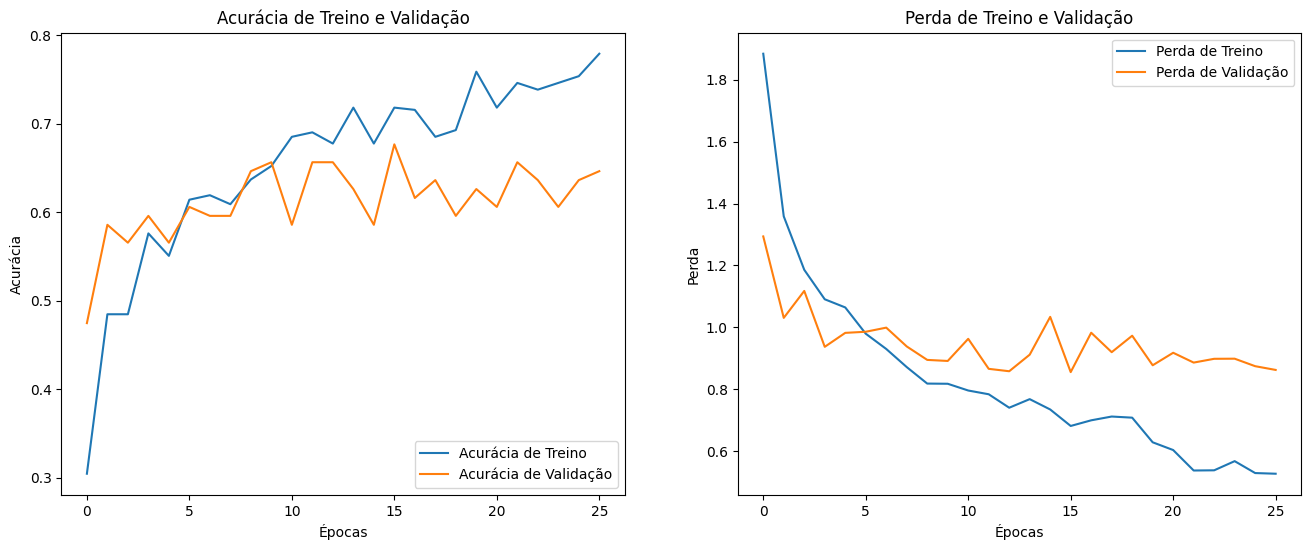

In [ ]:
import matplotlib.pyplot as plt

# --- Fun√ß√£o para plotar o hist√≥rico de treinamento ---
def plotar_historico(history):
    """Plota os gr√°ficos de acur√°cia e perda do treinamento e valida√ß√£o."""

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 6))

    # Gr√°fico de Acur√°cia
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Acur√°cia de Treino')
    plt.plot(epochs_range, val_acc, label='Acur√°cia de Valida√ß√£o')
    plt.legend(loc='lower right')
    plt.title('Acur√°cia de Treino e Valida√ß√£o')
    plt.xlabel('√âpocas')
    plt.ylabel('Acur√°cia')

    # Gr√°fico de Perda (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Perda de Treino')
    plt.plot(epochs_range, val_loss, label='Perda de Valida√ß√£o')
    plt.legend(loc='upper right')
    plt.title('Perda de Treino e Valida√ß√£o')
    plt.xlabel('√âpocas')
    plt.ylabel('Perda')

    plt.show()

# Chame a fun√ß√£o com o hist√≥rico do seu treinamento
plotar_historico(history)

--- Iniciando Passo 5: An√°lise do Melhor Modelo do Treino Inicial ---
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 2s/step

Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

          a2       0.85      0.75      0.80        55
           d       1.00      0.22      0.36         9
           e       0.38      0.50      0.43        12
           g       0.55      0.78      0.64        23

    accuracy                           0.68        99
   macro avg       0.69      0.56      0.56        99
weighted avg       0.74      0.68      0.68        99



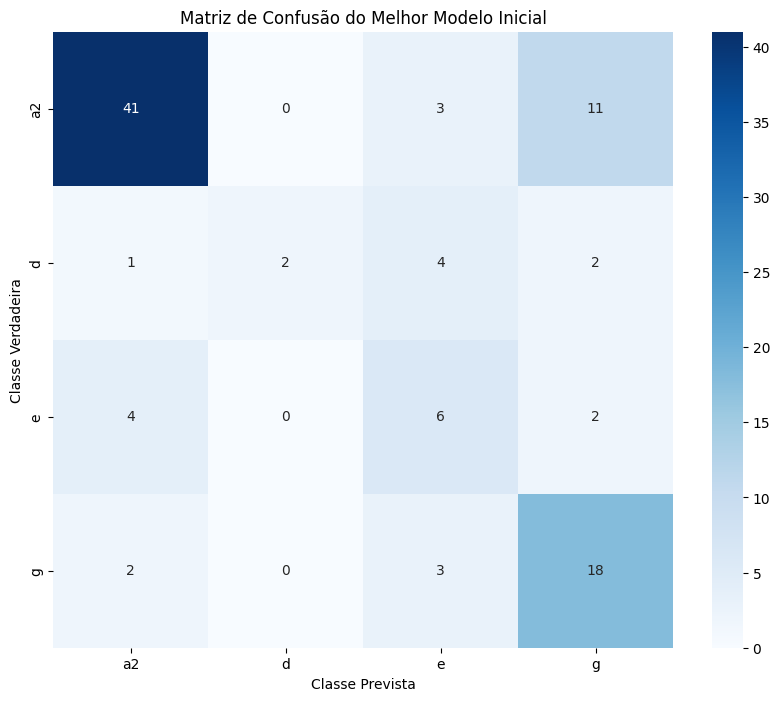

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ==============================================================================
# 1. CONFIGURA√á√ÉO
# ==============================================================================
# Par√¢metros para as fases de avalia√ß√£o e fine-tuning.

# Carrega o caminho do melhor modelo salvo no Passo 4.
BEST_MODEL_PATH = 'best_model_proof_of_concept.keras'

# Par√¢metros para o fine-tuning.
FINE_TUNE_EPOCHS = 30
FINE_TUNE_LEARNING_RATE = 0.0001 # Taxa de aprendizado 10x menor que a inicial.
FINE_TUNE_CHECKPOINT_PATH = 'best_model_fine_tuned.keras'
NUM_LAYERS_TO_UNFREEZE = 30 # N√∫mero de camadas a serem "descongeladas" no final do MobileNetV2.


# ==============================================================================
# PASSO 5: AN√ÅLISE DETALHADA DO MELHOR MODELO INICIAL
# ==============================================================================
print("--- Iniciando Passo 5: An√°lise do Melhor Modelo do Treino Inicial ---")

# Carrega o melhor modelo salvo.
try:
    model = tf.keras.models.load_model(BEST_MODEL_PATH)
except Exception as e:
    print(f"Erro ao carregar o modelo. Verifique se o arquivo '{BEST_MODEL_PATH}' existe e se o treinamento anterior foi conclu√≠do.")
    raise e

# Faz predi√ß√µes no conjunto de valida√ß√£o.
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# 1. Relat√≥rio de Classifica√ß√£o
# Mostra precis√£o, recall e f1-score para cada classe.
print("\nRelat√≥rio de Classifica√ß√£o:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# 2. Matriz de Confus√£o
# Mostra visualmente onde o modelo est√° acertando e errando.
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confus√£o do Melhor Modelo Inicial')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()

In [ ]:
# ==============================================================================
# PASSO 6: PREPARA√á√ÉO E EXECU√á√ÉO DO FINE-TUNING
# ==============================================================================
print("\n--- Iniciando Passo 6: Fine-Tuning ---")

# Descongela as √∫ltimas N camadas do modelo base para um ajuste fino.
base_model = model.layers[0]
base_model.trainable = True

for layer in base_model.layers[:-NUM_LAYERS_TO_UNFREEZE]:
    layer.trainable = False

print(f"\nModelo base descongelado. As √∫ltimas {NUM_LAYERS_TO_UNFREEZE} camadas agora s√£o trein√°veis.")

# Re-compila o modelo com uma taxa de aprendizado muito mais baixa.
# Isso √© CRUCIAL para n√£o destruir os pesos pr√©-treinados.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Define novos callbacks para o fine-tuning.
fine_tune_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath=FINE_TUNE_CHECKPOINT_PATH, monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
]

print("\nIniciando o treinamento de Fine-Tuning...")

# Continua o treinamento a partir de onde o anterior parou.
initial_epochs = len(history.epoch)

fine_tune_history = model.fit(
    train_generator,
    epochs=initial_epochs + FINE_TUNE_EPOCHS,
    initial_epoch=initial_epochs, # Continua a contagem das √©pocas.
    validation_data=validation_generator,
    class_weight=class_weights_dict, # Continua usando os pesos.
    callbacks=fine_tune_callbacks
)

print("-" * 50)
print(f"Fine-Tuning conclu√≠do. O melhor modelo refinado foi salvo em '{FINE_TUNE_CHECKPOINT_PATH}'.")


# ==============================================================================
# AVALIA√á√ÉO FINAL (VISUALIZA√á√ÉO P√ìS-FINE-TUNING)
# ==============================================================================

# Combina o hist√≥rico do treinamento inicial com o do fine-tuning para um gr√°fico completo.
history.history['accuracy'].extend(fine_tune_history.history['accuracy'])
history.history['val_accuracy'].extend(fine_tune_history.history['val_accuracy'])
history.history['loss'].extend(fine_tune_history.history['loss'])
history.history['val_loss'].extend(fine_tune_history.history['val_loss'])

# Plota os gr√°ficos combinados.
plotar_historico(history)



--- Iniciando Passo 6: Fine-Tuning ---

Modelo base descongelado. As √∫ltimas 30 camadas agora s√£o trein√°veis.


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ mobilenetv2_1.00_224            ‚îÇ (None, 7, 7, 1280)     ‚îÇ     2,257,984 ‚îÇ
‚îÇ (Functional)                    ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d        ‚îÇ (None, 1280)           ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 1280)           ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 128)            ‚îÇ       163,968 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 4)              ‚îÇ           516 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 1,690,884 (6.45 MB)

 Non-trainable params: 731,584 (2.79 MB)


Iniciando o treinamento de Fine-Tuning...
Epoch 27/56
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 64s 4s/step - accuracy: 0.6133 - loss: 1.0886 - val_accuracy: 0.6465 - val_loss: 1.0001 - learning_rate: 1.0000e-04
Epoch 28/56
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 73s 3s/step - accuracy: 0.6941 - loss: 0.7192 - val_accuracy: 0.6364 - val_loss: 1.0613 - learning_rate: 1.0000e-04
Epoch 29/56
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 84s 3s/step - accuracy: 0.6725 - loss: 0.7435 - val_accuracy: 0.6566 - val_loss: 1.1029 - learning_rate: 1.0000e-04
Epoch 30/56
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 78s 3s/step - accuracy: 0.7581 - loss: 0.5240 - val_accuracy: 0.6263 - val_loss: 1.1204 - learning_rate: 1.0000e-04
Epoch 31/56
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 42s 3s/step - accuracy: 0.7371 - loss: 0.5489 - val_accuracy: 0.6364 - val_loss: 1.1353 - learning

In [ ]:

BEST_MODEL_PATH = 'best_model_fine_tuned.keras'

# ==============================================================================
# PASSO 5: AN√ÅLISE DETALHADA DO MELHOR MODELO INICIAL
# ==============================================================================
print("--- Iniciando Passo 5: An√°lise do Melhor Modelo do Treino Inicial ---")

# Carrega o melhor modelo salvo.
try:
    model = tf.keras.models.load_model(BEST_MODEL_PATH)
except Exception as e:
    print(f"Erro ao carregar o modelo. Verifique se o arquivo '{BEST_MODEL_PATH}' existe e se o treinamento anterior foi conclu√≠do.")
    raise e

# Faz predi√ß√µes no conjunto de valida√ß√£o.
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# 1. Relat√≥rio de Classifica√ß√£o
# Mostra precis√£o, recall e f1-score para cada classe.
print("\nRelat√≥rio de Classifica√ß√£o:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# 2. Matriz de Confus√£o
# Mostra visualmente onde o modelo est√° acertando e errando.
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confus√£o do Melhor Modelo Fine-tuning')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()

--- Iniciando Passo 5: An√°lise do Melhor Modelo do Treino Inicial ---
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 2s/step

Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

          a2       0.87      0.71      0.78        55
           d       1.00      0.22      0.36         9
           e       0.36      0.33      0.35        12
           g       0.46      0.83      0.59        23

    accuracy                           0.65        99
   macro avg       0.67      0.52      0.52        99
weighted avg       0.72      0.65      0.65        99




### **Relat√≥rio T√©cnico: Classifica√ß√£o de Modos de Ruptura em Corpos de Prova Rochosos via Deep Learning**




O presente estudo teve como objetivo desenvolver e avaliar um modelo de Aprendizado Profundo (Deep Learning) para a classifica√ß√£o autom√°tica de diferentes modos de ruptura em corpos de prova rochosos submetidos a ensaios de compress√£o uniaxial.

#### **Metodologia**

A metodologia foi executada em fases sequenciais, partindo da prepara√ß√£o dos dados at√© o treinamento e refinamento de uma Rede Neural Convolucional (CNN).

**Prepara√ß√£o do Dataset**

O dataset inicial consistiu em 137 registros de corpos de prova, cada um associado a m√∫ltiplas imagens de vistas laterais. As imagens individuais foram extra√≠das e organizadas em diret√≥rios correspondentes √†s suas classes de ruptura, resultando em um total de 535 imagens. A an√°lise explorat√≥ria revelou um severo desbalanceamento entre as classes, conforme detalhado na Tabela 1.

**Tabela 1: Distribui√ß√£o das amostras por classe de ruptura.**

| Classe | Contagem de Amostras | % do Total |
| :--- | :--- | :--- |
| **a2** | 70 | 51.1% |
| **g** | 30 | 21.9% |
| **e** | 16 | 11.7% |
| **d** | 12 | 8.8% |
| **a1** | 7 | 5.1% |
| **f** | 2 | 1.5% |

**Defini√ß√£o da Prova de Conceito**

Devido √† escassez de dados para as classes `a1` e `f`, foi definida uma prova de conceito focada nas quatro classes mais populosas (`a2`, `g`, `e`, `d`), totalizando 493 imagens para o desenvolvimento do modelo inicial. Os dados foram divididos de forma estratificada em 80% para treino (394 imagens) –∏ 20% para valida√ß√£o (99 imagens).

**Arquitetura do Modelo**

Foi adotada a abordagem de **Aprendizagem por Transfer√™ncia (Transfer Learning)**, utilizando a arquitetura **MobileNetV2** pr√©-treinada no dataset ImageNet. Um classificador customizado foi adicionado ao topo do modelo base, consistindo em camadas de `GlobalAveragePooling2D`, `Dropout` para regulariza√ß√£o, e `Dense` para a classifica√ß√£o final.

**Estrat√©gia de Treinamento**

O treinamento foi conduzido em duas fases:

* **Fase 1 - Treinamento Inicial:** As camadas do modelo base MobileNetV2 foram congeladas, treinando-se apenas o classificador adicionado. Para mitigar o desbalanceamento, foi aplicada a t√©cnica de `class_weight`, que atribui pesos maiores √†s classes minorit√°rias durante o c√°lculo da fun√ß√£o de perda.

* **Fase 2 - Ajuste Fino (Fine-Tuning):** Ap√≥s o treinamento inicial, as 30 camadas finais do modelo base foram "descongeladas" e o treinamento foi continuado com uma taxa de aprendizado 10 vezes menor. O objetivo desta fase foi especializar o modelo nas caracter√≠sticas sutis das imagens do projeto.

#### **Resultados e An√°lise**

A avalia√ß√£o do modelo foi realizada em ambas as fases, com os seguintes resultados para o conjunto de valida√ß√£o.

**Desempenho do Modelo Inicial**

O primeiro modelo atingiu uma acur√°cia geral de **70%**. A an√°lise detalhada (Tabela 2) e a matriz de confus√£o revelaram um bom desempenho para a classe `a2`, mas uma performance significativamente inferior para as classes minorit√°rias, com um forte vi√©s de predi√ß√£o para a classe `a2` em casos de incerteza.

**Desempenho do Modelo P√≥s-Ajuste Fino**

Ap√≥s o Fine-Tuning, a acur√°cia geral foi de **66%**. Embora a m√©trica global tenha diminu√≠do, a an√°lise qualitativa revelou um modelo mais equilibrado.

**Tabela 2: Comparativo do Recall por classe entre os modelos.**

| Classe | Recall - Modelo Inicial | Recall - Modelo P√≥s-Fine-Tuning | Varia√ß√£o |
| :--- | :--- | :--- | :--- |
| **a2** | 91% | 78% | üîª -13 pts |
| **d** | 33% | 22% | üîª -11 pts |
| **e** | 25% | 25% | ‚ñ¨ 0 pts |
| **g** | 57% | **74%** | ‚ñ≤ **+17 pts** |

A an√°lise evidencia que o Fine-Tuning reduziu o vi√©s do modelo para a classe `a2`, resultando em uma melhora substancial na sua capacidade de identificar corretamente a segunda classe mais comum, `g`. A queda na acur√°cia geral √© atribu√≠da √† redu√ß√£o da performance na classe `a2`, que n√£o √© mais prevista de forma t√£o agressiva. As classes `d` e `e` permaneceram como um desafio devido √† alta escassez de dados.

#### **Conclus√µes**

O estudo confirmou a viabilidade da utiliza√ß√£o de modelos de Deep Learning para a classifica√ß√£o de modos de ruptura de rochas. O principal desafio identificado √© a limita√ß√£o e o desbalanceamento do dataset. A estrat√©gia de Fine-Tuning foi eficaz em criar um modelo mais balanceado e menos propenso a "chutar" a classe majorit√°ria, tornando-o potencialmente mais √∫til para uma aplica√ß√£o pr√°tica. O modelo `best_model_fine_tuned.keras` representa o artefato de melhor desempenho gerado nesta fase do projeto.

#### **Pr√≥ximos Passos Propostos**

Com base nos resultados obtidos, as seguintes etapas s√£o recomendadas para a continua√ß√£o do projeto:

1.  **Implementa√ß√£o Pr√°tica:** Desenvolver uma fun√ß√£o ou aplica√ß√£o simples para utilizar o modelo refinado na classifica√ß√£o de novas imagens, validando seu comportamento em dados completamente novos.
2.  **Expans√£o do Modelo:** Investigar a inclus√£o da classe `a1` no treinamento, empregando t√©cnicas de Data Augmentation mais agressivas para compensar o baixo n√∫mero de amostras.



Para aprimorar o desempenho do modelo atual e mitigar as limita√ß√µes observadas, as seguintes a√ß√µes de otimiza√ß√£o e melhoria de performance s√£o recomendadas.

**Ajuste de Hiperpar√¢metros**
A performance de um modelo de Deep Learning √© sens√≠vel √†s configura√ß√µes utilizadas durante o treinamento, conhecidas como hiperpar√¢metros. A experimenta√ß√£o sistem√°tica com estes valores pode levar a ganhos de performance significativos. Os principais candidatos para ajuste s√£o:
* **Taxa de Aprendizado (Learning Rate):** Testar valores ligeiramente maiores ou menores (ex: `5e-5` ou `1e-3`) pode permitir que o otimizador encontre um m√≠nimo melhor na fun√ß√£o de perda.
* **Taxa de Dropout:** Aumentar ou diminuir a taxa de dropout pode ajudar a encontrar um balan√ßo mais eficaz entre o aprendizado dos padr√µes e a regulariza√ß√£o contra o overfitting.
* **N√∫mero de Camadas Descongeladas:** O valor de 30 camadas para o Fine-Tuning foi uma escolha emp√≠rica. Testar a performance descongelando um n√∫mero maior ou menor de camadas (ex: 20, 40 ou 50) pode revelar uma configura√ß√£o √≥tima para a especializa√ß√£o do modelo.

**Experimenta√ß√£o com Outras Arquiteturas de Modelo**
A arquitetura MobileNetV2 foi escolhida por sua efici√™ncia, mas outras arquiteturas pr√©-treinadas podem ter aprendido representa√ß√µes de caracter√≠sticas mais adequadas para este problema espec√≠fico. A substitui√ß√£o do modelo base √© uma etapa avan√ßada para buscar um novo patamar de acur√°cia. Arquiteturas recomendadas para experimenta√ß√£o incluem:
* **`EfficientNetV2`:** Uma fam√≠lia de modelos modernos conhecidos por alcan√ßar alta acur√°cia com grande efici√™ncia computacional.
* **`ResNet50`:** Uma arquitetura cl√°ssica e extremamente robusta, cujas conex√µes residuais permitem o treinamento eficaz de redes muito profundas, podendo capturar padr√µes mais complexos.
* **`DenseNet`:** Uma arquitetura que conecta cada camada a todas as camadas subsequentes, melhorando o fluxo de gradientes e a reutiliza√ß√£o de caracter√≠sticas.

**Coleta de Mais Dados (A√ß√£o de Maior Impacto)**
Constata-se que a principal limita√ß√£o do projeto √© a quantidade e o desbalanceamento dos dados. Modelos de Deep Learning s√£o inerentemente "famintos por dados", e sua performance √© diretamente proporcional √† qualidade e volume do dataset de treinamento.
* **Foco Estrat√©gico:** A a√ß√£o de maior impacto seria a coleta de novas amostras, com foco especial nas **classes minorit√°rias** (`d` e `e`), que o modelo demonstrou maior dificuldade em aprender.
* **Benef√≠cio Esperado:** Um aumento no n√∫mero de exemplos para estas classes permitiria ao modelo aprender seus padr√µes visuais de forma mais robusta, reduzindo a confus√£o com as classes majorit√°rias e elevando significativamente todas as m√©tricas de desempenho (precis√£o, recall e acur√°cia geral). Nenhuma otimiza√ß√£o de hiperpar√¢metros ou arquitetura pode substituir o impacto positivo de um dataset maior e mais equilibrado.